In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#from sklearn import OneHotEncoder

# per importare cose nella folder precedente da ora in poi
import sys
sys.path.append('../')

from layer import HiddenLayer
from activations import *
from losses import *
from network import Network
from regularizers import *
from utils import *
from metrics import *
from validation import *
from gridsearch import grid_search

random.seed(42)
np.random.seed(42)

# Progress bar
from tqdm import tqdm
import time

In [7]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [8]:
from sklearn.preprocessing import MinMaxScaler
rescaler = MinMaxScaler()
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
rescaler.fit(y_train)
y_train = rescaler.transform(y_train)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

In [11]:
seed = 3
np.random.seed(seed)
net = Network(MSE(1), eta=1e-3)

net.add_layer(
    input_size=len(X_train[0]),
    units_size=32,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=ReLU(),
    momentum=('Nesterov', 0.9),
)

net.add_layer(
    input_size=32,
    units_size=32,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=ReLU(),
    momentum=('Nesterov', 0.9),
)

net.add_layer(
    input_size=32,
    units_size=3,
    starting=Range_random(),
    regularizer=L2(lambda_=1e-8),
    activation=Identity(),
    momentum=('Nesterov', 0.9),
)

In [4]:
X_split = np.array_split(X_train, 5)
y_split = np.array_split(y_train, 5)

X_train = np.concatenate(X_split[:4] + (X_split[4 + 1:]))
y_train = np.concatenate(y_split[:4] + (y_split[4 + 1:]))

X_val = X_split[4]
y_val = y_split[4]

Epochs:  40%|███▉      | 3964/10000 [06:42<10:12,  9.85it/s]  


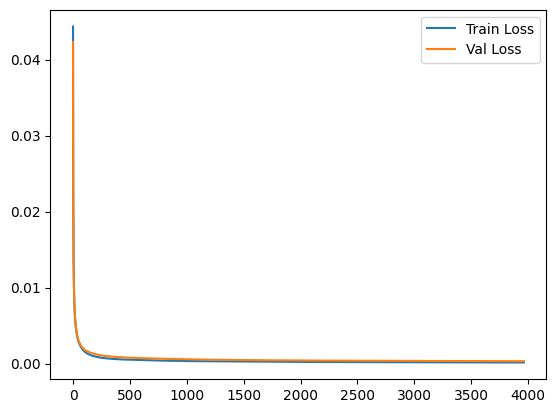

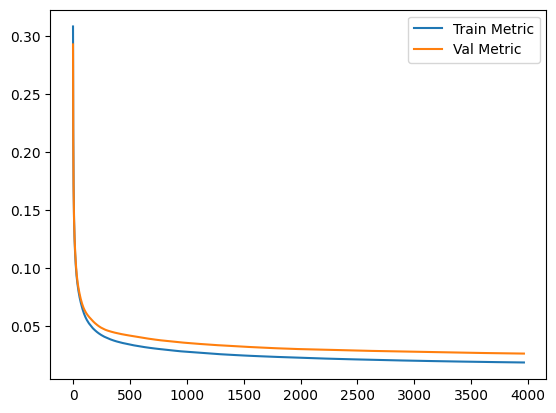

In [13]:
info = net.train(
    X_train, 
    y_train,
    X_val,
    y_val,
    10000,
    100,
    MEE()
)
plt.plot(info['tr_losses'], label='Train Loss')
plt.plot(info['val_losses'], label='Val Loss')
plt.legend()
plt.show()

plt.plot(info['tr_metrics'], label='Train Metric')
plt.plot(info['val_metrics'], label='Val Metric')
plt.legend()
plt.show()

In [15]:
print(net.statistics(X_train, y_train, MEE()))
print(net.statistics(X_val, y_val, MEE()))

(0.00014487693677929463, 0.018368050137334523)
(0.00031508128630263827, 0.026063237516497265)


In [ ]:
statistics = kfold_crossval(
    X=X_train,
    y=y_train,
    k=6,
    net=net,
    epochs=2500,
    patience=100,
    seed=seed,
    metric=MEE()
)

print(statistics)

Combination: [32, 32, 3] ReLU Range_random (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 0.01


Epochs:  12%|█▏        | 1191/10000 [02:07<15:42,  9.34it/s]


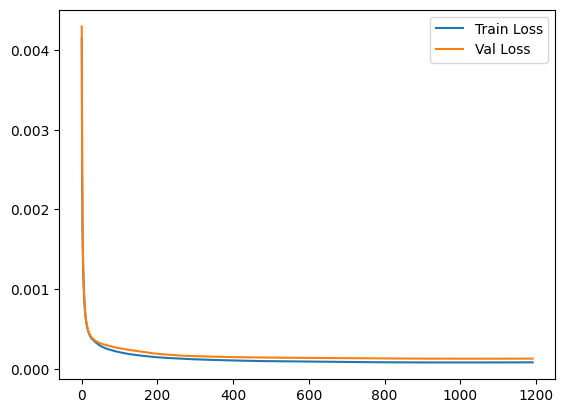

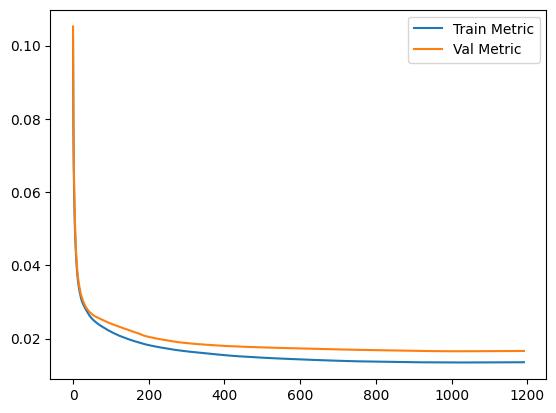

Fold 1 of 6 completed
Train Loss: 7.878900104093006e-05
Train Metric: 0.013508637859300274
Val Loss: 0.00012632986487355136
Val Metric: 0.016597325846864613


Epochs:  15%|█▍        | 1459/10000 [02:31<14:44,  9.66it/s]


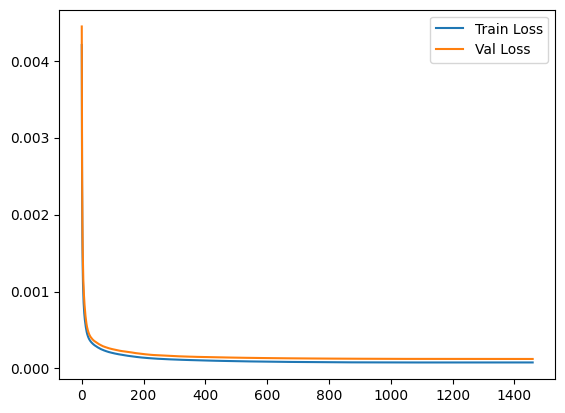

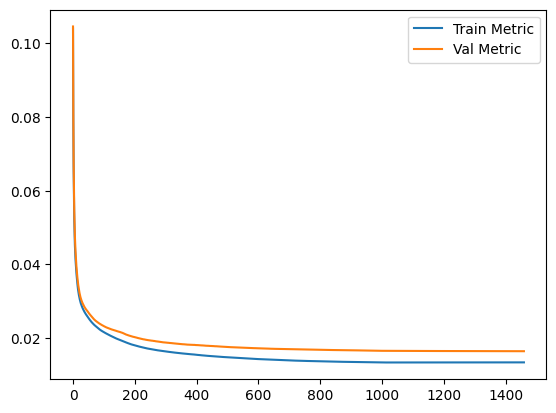

Fold 2 of 6 completed
Train Loss: 7.826381781733323e-05
Train Metric: 0.013372199731061988
Val Loss: 0.0001243315256363918
Val Metric: 0.016466789921541963


Epochs:  13%|█▎        | 1304/10000 [02:14<15:00,  9.66it/s]


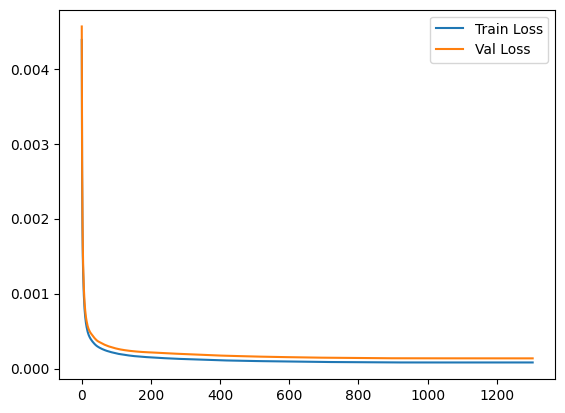

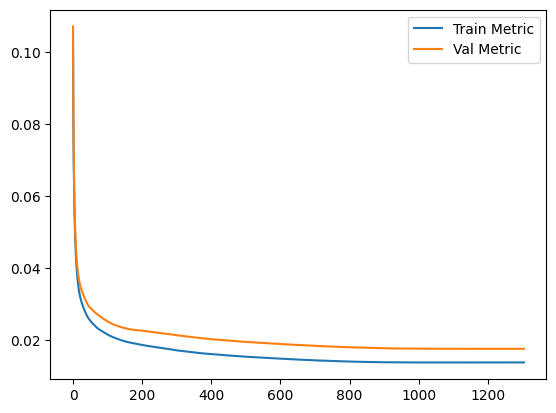

Fold 3 of 6 completed
Train Loss: 8.243217276971275e-05
Train Metric: 0.013789979685064077
Val Loss: 0.00013769460809695238
Val Metric: 0.017600349847347


Epochs:  10%|█         | 1035/10000 [01:47<15:27,  9.67it/s]


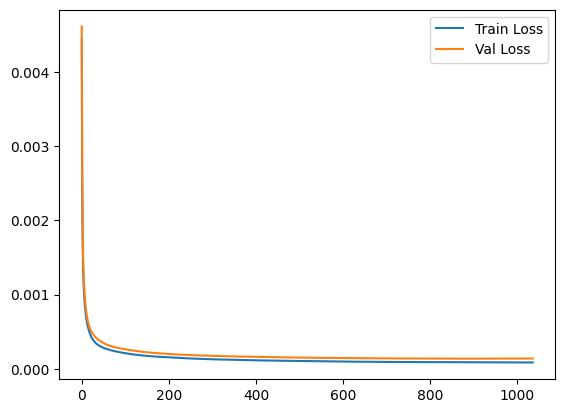

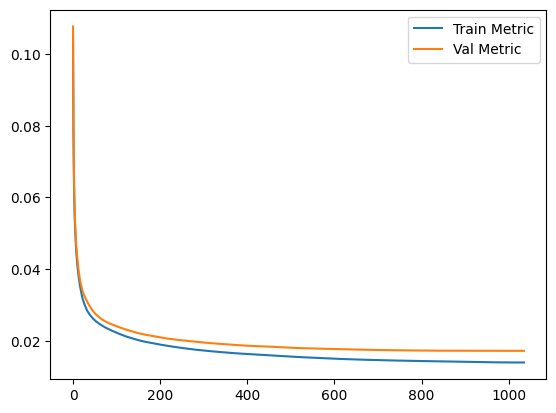

Fold 4 of 6 completed
Train Loss: 9.078800395154337e-05
Train Metric: 0.014388868730512663
Val Loss: 0.0001389543484403997
Val Metric: 0.017288616030973494


Epochs:  14%|█▍        | 1395/10000 [02:25<14:55,  9.61it/s]


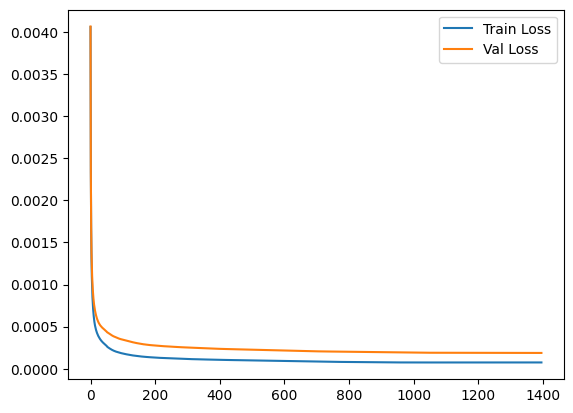

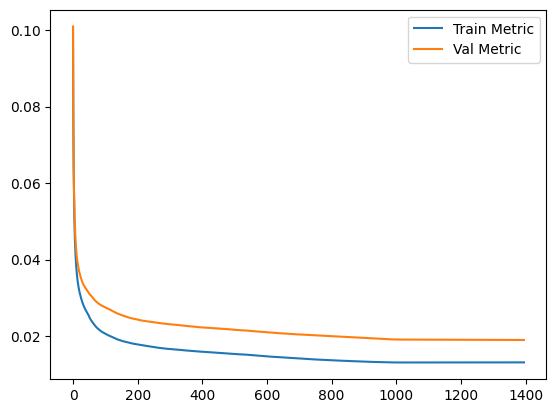

Fold 5 of 6 completed
Train Loss: 7.508566874915831e-05
Train Metric: 0.013126898122951106
Val Loss: 0.00018987500069629818
Val Metric: 0.019068633313825765


Epochs:  12%|█▏        | 1226/10000 [02:06<15:07,  9.67it/s]


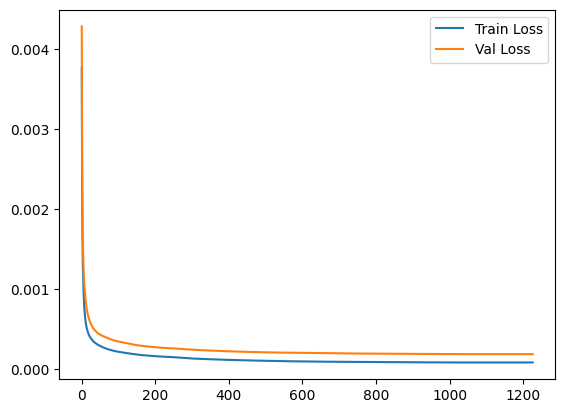

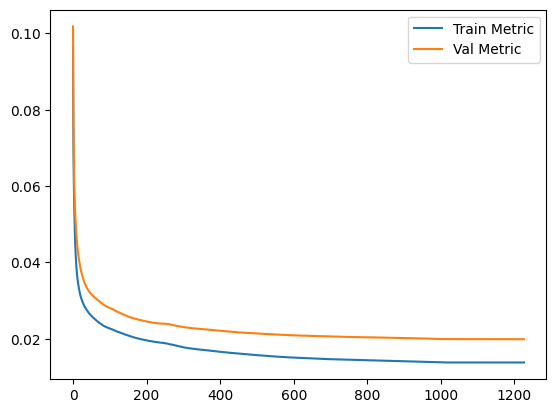

Fold 6 of 6 completed
Train Loss: 8.212317554424189e-05
Train Metric: 0.013889070254535736
Val Loss: 0.00018713151989937
Val Metric: 0.020032269969897636
Combination: [32, 32, 3] ReLU Range_random (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 0.01
Statistics: {'tr_loss': 8.124697331215326e-05, 'tr_metric': 0.013679275730570975, 'val_loss': 0.0001507194779404939, 'val_metric': 0.017842330821741744}




Combination: [32, 32, 3] ReLU Range_random (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 500.0


Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\chucki\Desktop\projects\ML-project\notebooks\..\layer.py:69: RuntimeWarning: invalid value encountered in multiply
  delta = curr_delta * self.activation.derivative(self.net)
c:\Users\chucki\Desktop\projects\ML-project\notebooks\..\layer.py:80: RuntimeWarning: invalid value encountered in multiply
  self.W -= eta * delta_grad - alpha * self.delta_old + self.regularizer.derivative(W)
Epochs:   2%|▎         | 250/10000 [00:24<16:13, 10.02it/s]


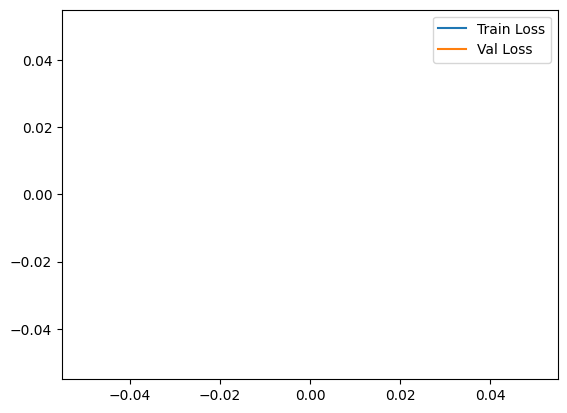

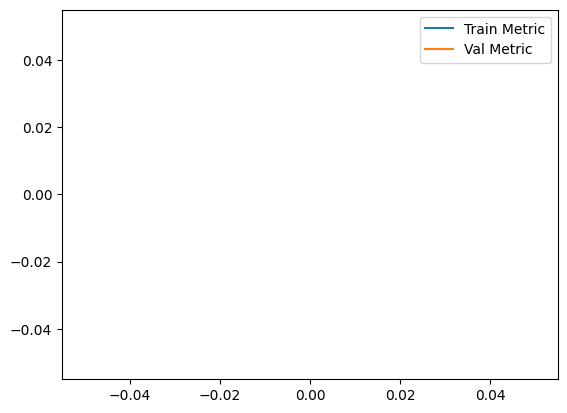

Fold 1 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:23, 10.56it/s]


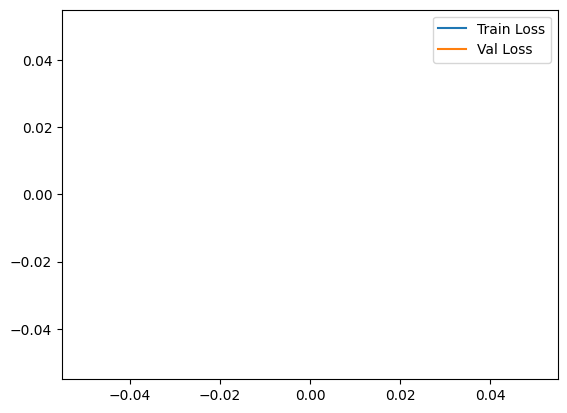

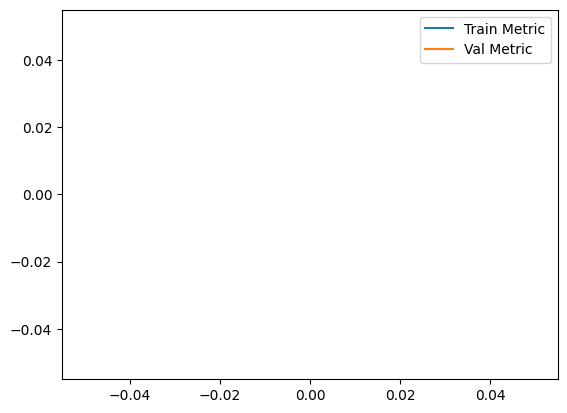

Fold 2 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:26, 10.53it/s]


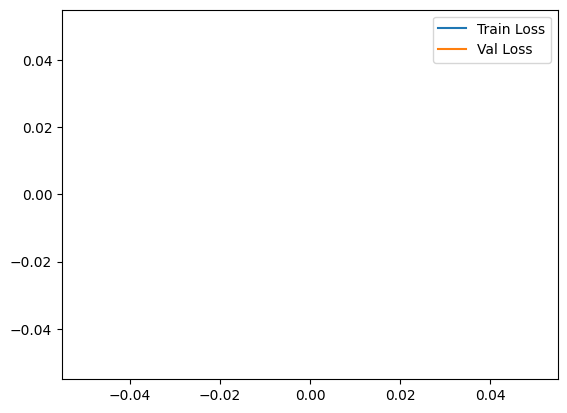

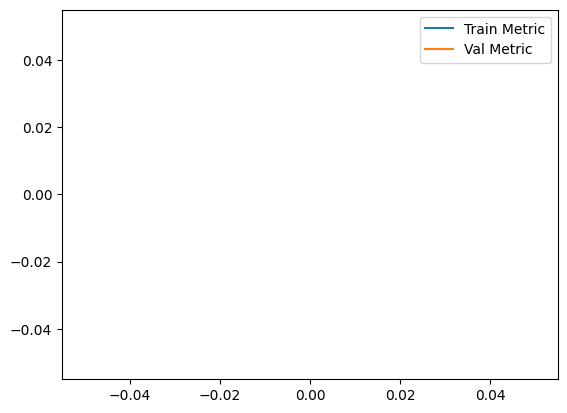

Fold 3 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:34, 10.43it/s]


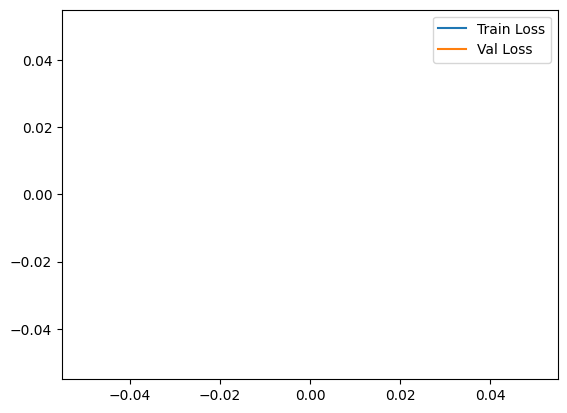

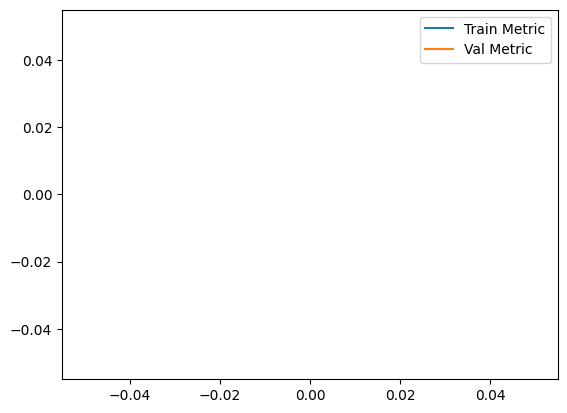

Fold 4 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:23, 10.55it/s]


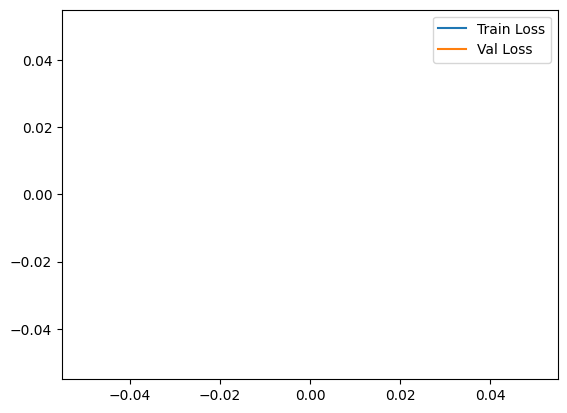

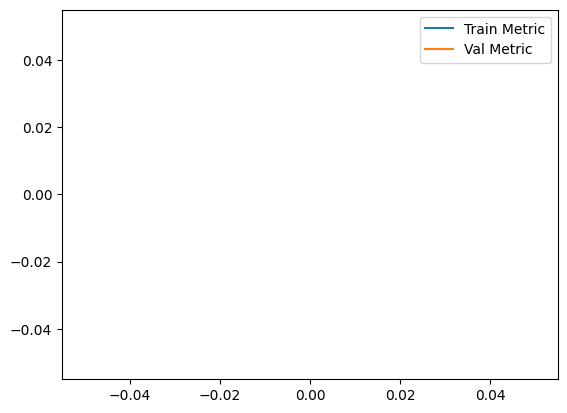

Fold 5 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:26, 10.53it/s]


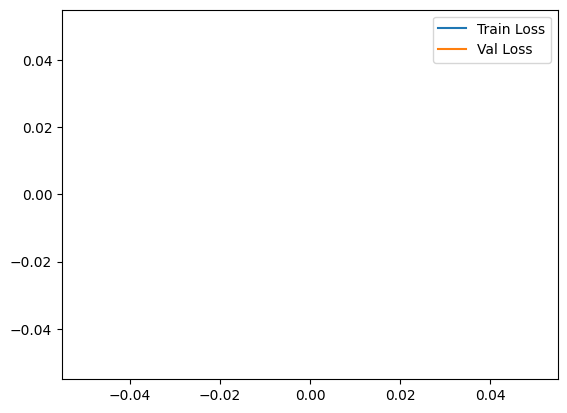

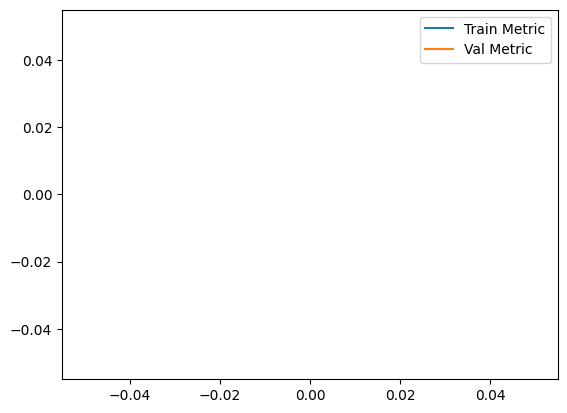

Fold 6 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan
Combination: [32, 32, 3] ReLU Range_random (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 500.0
Statistics: {'tr_loss': nan, 'tr_metric': nan, 'val_loss': nan, 'val_metric': nan}




Combination: [32, 32, 3] ReLU Fan_in (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 0.01


Epochs:  12%|█▏        | 1174/10000 [01:50<13:50, 10.63it/s]


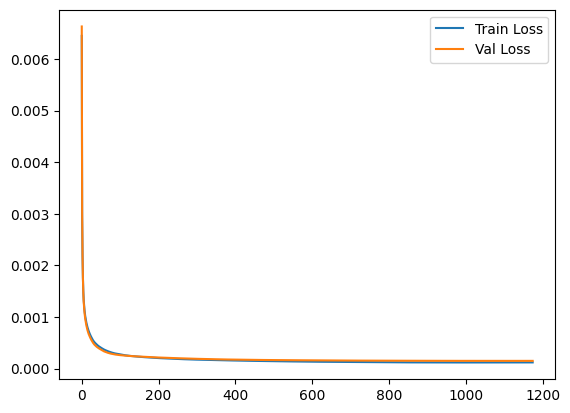

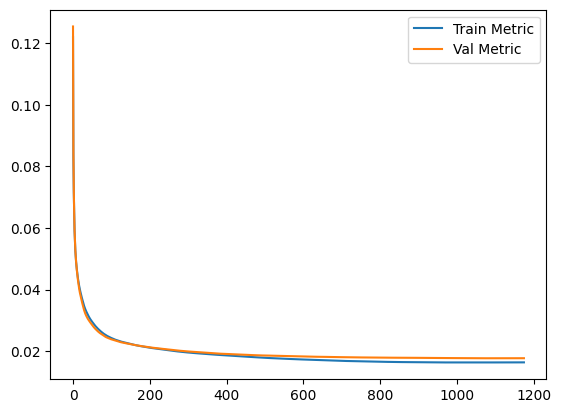

Fold 1 of 6 completed
Train Loss: 0.00011954107969238657
Train Metric: 0.016400584424733175
Val Loss: 0.0001512726699810533
Val Metric: 0.017840011963544077


Epochs:  13%|█▎        | 1296/10000 [02:02<13:40, 10.60it/s]


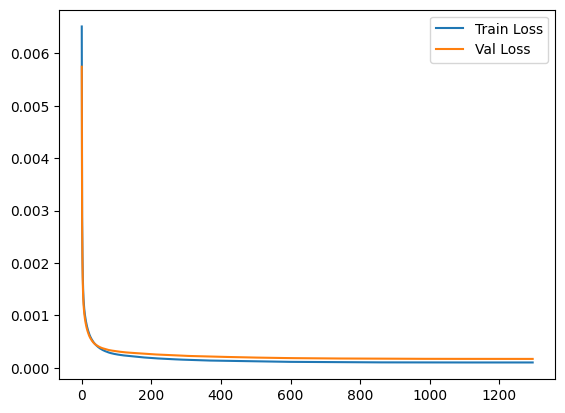

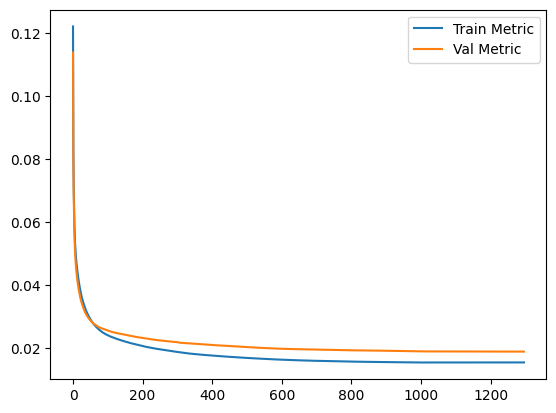

Fold 2 of 6 completed
Train Loss: 0.00010327070979701819
Train Metric: 0.015449142193866028
Val Loss: 0.0001721332049440996
Val Metric: 0.018948044597892393


Epochs:  12%|█▏        | 1158/10000 [01:50<14:05, 10.46it/s]


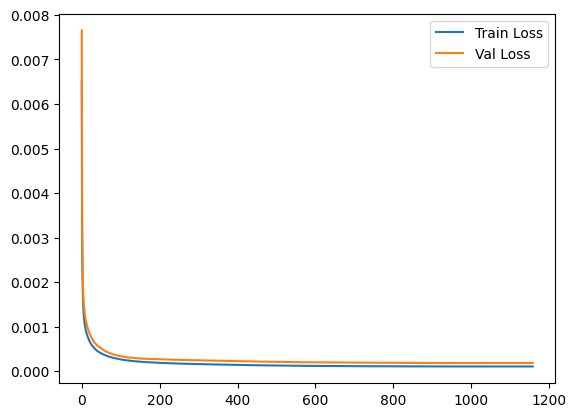

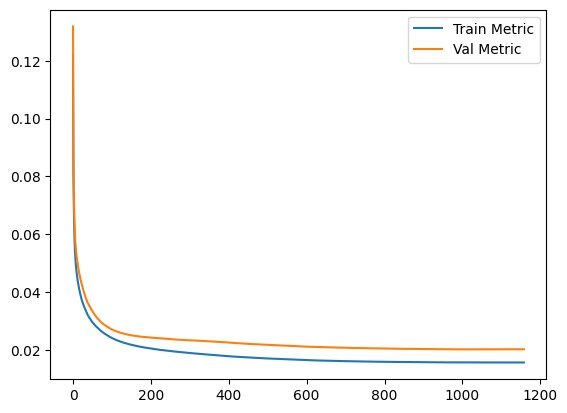

Fold 3 of 6 completed
Train Loss: 0.000109874498396867
Train Metric: 0.015729567541514198
Val Loss: 0.00018671670835471857
Val Metric: 0.020256553887981036


Epochs:  12%|█▏        | 1165/10000 [01:50<13:56, 10.57it/s]


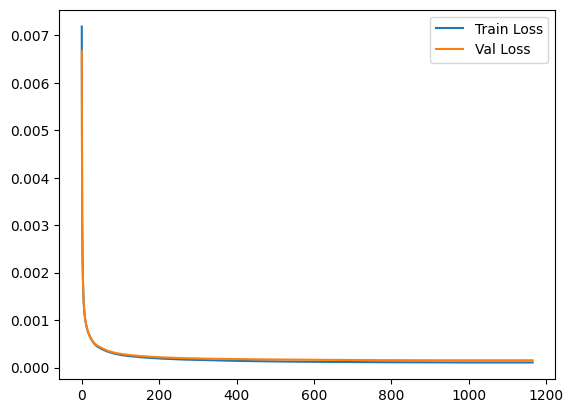

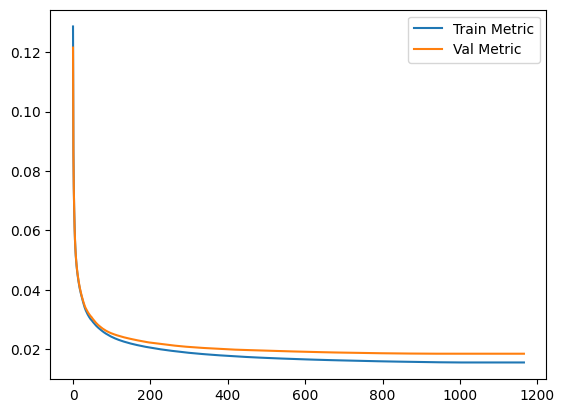

Fold 4 of 6 completed
Train Loss: 0.00010759288046127866
Train Metric: 0.015708433550170722
Val Loss: 0.00015330804169737768
Val Metric: 0.018546257590985497


Epochs:  14%|█▍        | 1405/10000 [02:12<13:31, 10.59it/s]


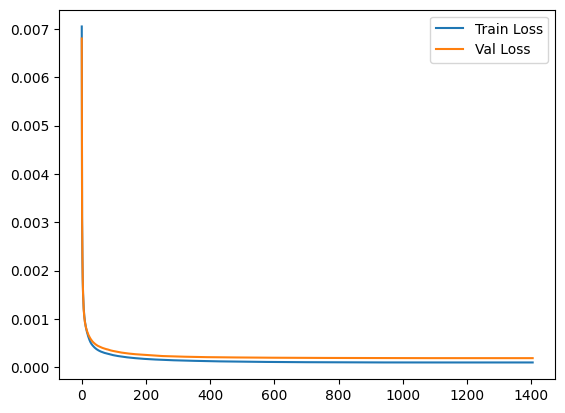

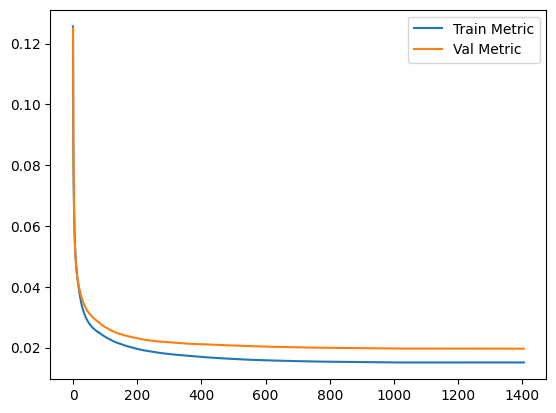

Fold 5 of 6 completed
Train Loss: 0.0001001691788167389
Train Metric: 0.015119848781274044
Val Loss: 0.00018979807910041136
Val Metric: 0.019681613638413774


Epochs:  12%|█▏        | 1203/10000 [01:53<13:50, 10.59it/s]


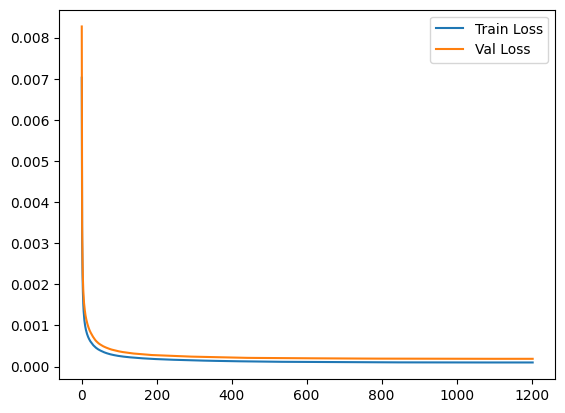

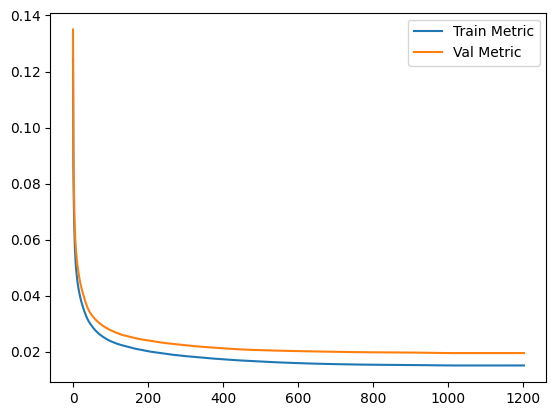

Fold 6 of 6 completed
Train Loss: 0.00010127799839839866
Train Metric: 0.015245447039951992
Val Loss: 0.00019021064849322574
Val Metric: 0.019683368240602354
Combination: [32, 32, 3] ReLU Fan_in (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 0.01
Statistics: {'tr_loss': 0.00010695439092711466, 'tr_metric': 0.015608837255251693, 'val_loss': 0.0001739065587618144, 'val_metric': 0.019159308319903187}




Combination: [32, 32, 3] ReLU Fan_in (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 500.0


Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]c:\Users\chucki\Desktop\projects\ML-project\notebooks\..\layer.py:86: RuntimeWarning: overflow encountered in multiply
  self.b -= eta * delta
Epochs:   2%|▎         | 250/10000 [00:24<15:36, 10.41it/s]


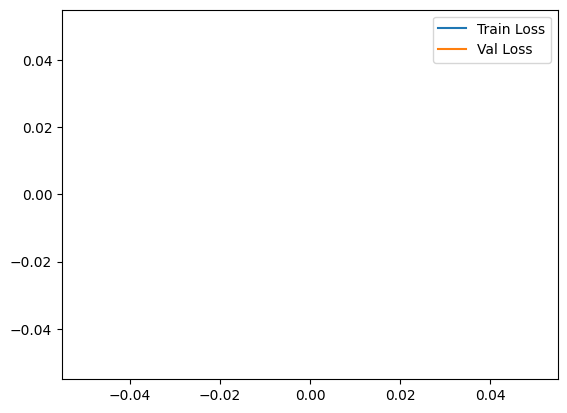

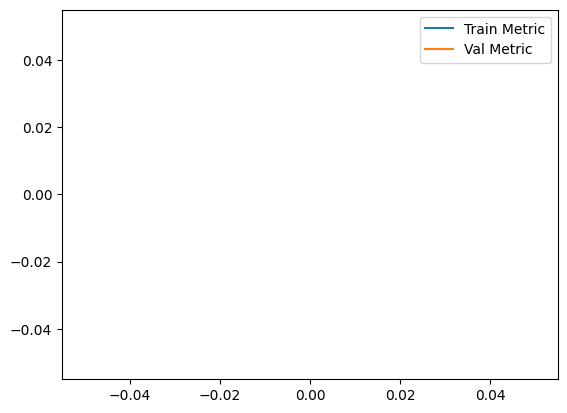

Fold 1 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:26, 10.52it/s]


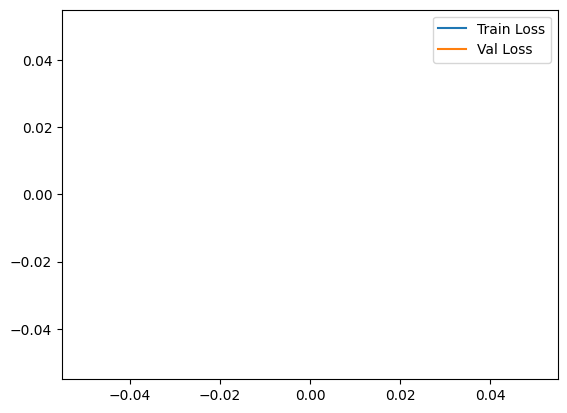

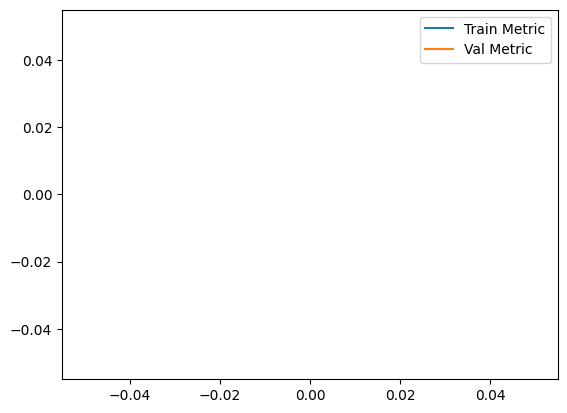

Fold 2 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:29, 10.49it/s]


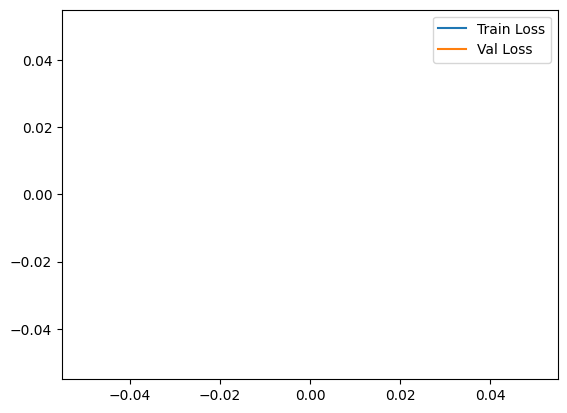

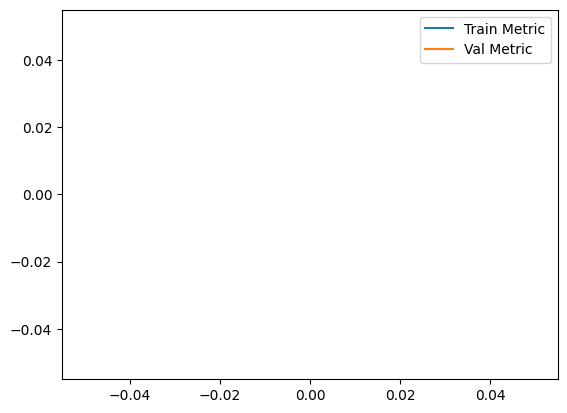

Fold 3 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:35, 10.42it/s]


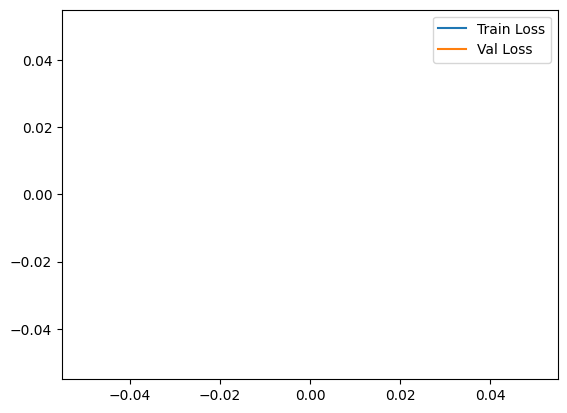

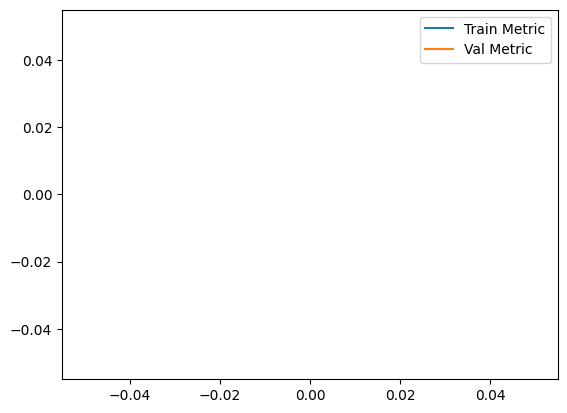

Fold 4 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:23<15:26, 10.53it/s]


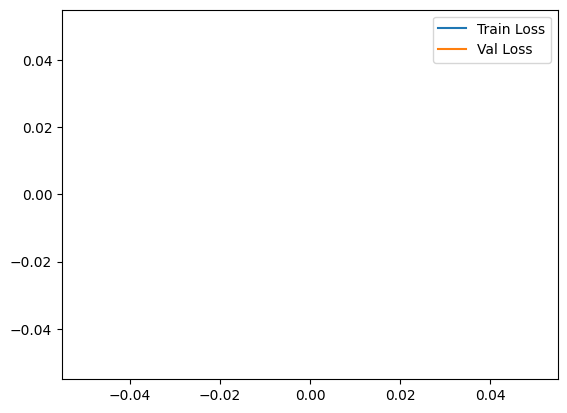

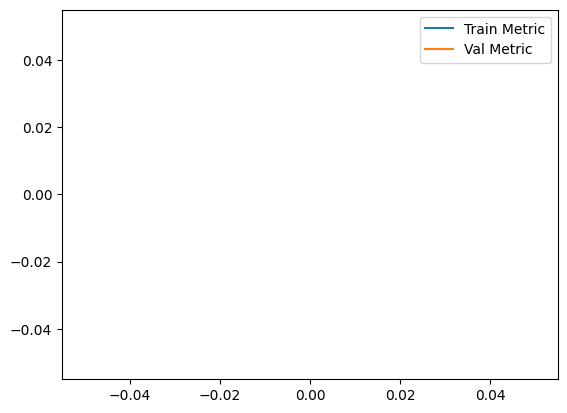

Fold 5 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan


Epochs:   2%|▎         | 250/10000 [00:24<15:36, 10.41it/s]


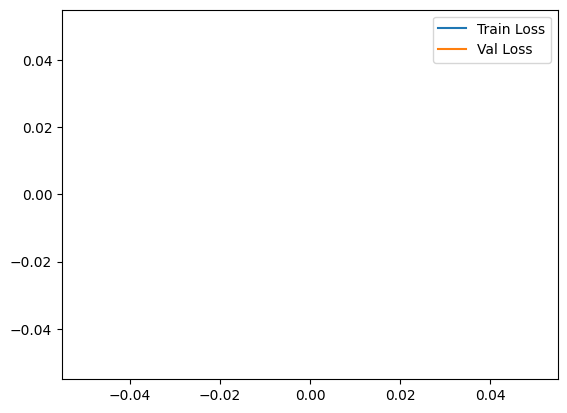

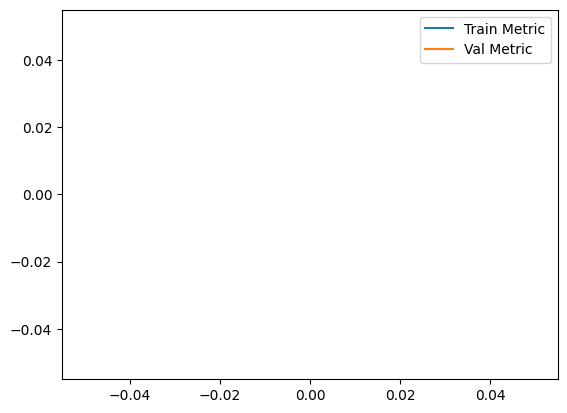

Fold 6 of 6 completed
Train Loss: nan
Train Metric: nan
Val Loss: nan
Val Metric: nan
Combination: [32, 32, 3] ReLU Fan_in (-0.3, 0.3) L2 1e-08 ('Nesterov', 0.9) 500.0
Statistics: {'tr_loss': nan, 'tr_metric': nan, 'val_loss': nan, 'val_metric': nan}






In [13]:
hyperparameters = {
    'layers_sizes': [[32, 32, 3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random", "Fan_in"],
    'startings_range': [(-0.3, 0.3)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-8],
    'momentums': [('Nesterov', 0.9)],
    'etas': [1e-2, 5e02],
}

data_to_csv = grid_search(
    hyperparams=hyperparameters,
    X=X_train,
    y=y_train,
    k=6,
    metric=MEE(),
    loss=MSE(1),
    seed=6,
    verbose=True
)

In [ ]:
X_train, y_train, test = read_cup("../data/ML-CUP23-TR.csv", "../data/ML-CUP23-TS.csv")

In [ ]:
# reshape ytrain eliminating last shape
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
y_train.shape

In [ ]:
# reshape Xtrain eliminating last shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_train.shape

In [ ]:
# use scikit-lear to make regression in 3d
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32,32),
    activation='relu',
    solver='sgd',
    alpha=0,
    batch_size=1,
    learning_rate_init=1e-3,
    max_iter=2500,
    shuffle=True,
    random_state=6,
    verbose=True,
    momentum=0,
    beta_1= 0,
    beta_2= 0.,
    epsilon= 1,
    validation_fraction = 0,
    nesterovs_momentum=False
)

mlp.fit(X_train, y_train)
# print the learning curve
plt.plot(mlp.loss_curve_)
plt.show()

# print the mean error
print(MEE()(y_train, mlp.predict(X_train)))

In [ ]:
import itertools

# Define the hyperparameters as dictionaries
hyperparameters = {
    'losses': ["MSE"],
    'layers_sizes': [[32,32,3],[16,16,16,3]],
    'activations': ["ReLU"], 
    'startings': ["Range_random"],
    'startings_range': [(-0.5, 0.5)],
    'regularizers': ["L2"],
    'regularizers_lambda': [1e-6, 1e-8],
    'momentums': [('Nesterov', 1e-4), ('Standard', 1e-4)],
    'etas': [1e-4]
}

# Create a list of all the possible combinations using itertools.product
hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

all_dics = []
# Print the result or use it as needed
for combination in hyperparameter_combinations:
    hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
    print(hyperparameter_dict)
    all_dics.append(hyperparameter_dict)

In [ ]:
for i in all_dics:
    print(*i.values())

In [ ]:
losses_ = "MSE"

startings_ = []
startings_range_ = []
activations_ = []
regularizers_ = []
regularizers_lambda_ = []
momentums_ = []


for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    startings_ = []
    activations_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    startings_range_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    
    print(layers_sizes_)
    print(activations_)
    print(startings_)
    print(startings_range_)
    print(regularizers_)
    print(regularizers_lambda_)
    print(momentums_)
    print(etas_)
    print("\n")

In [ ]:
data_to_csv = [["Loss func","Size", "Activation", "Starting", "Range", "Regularizer", "lambda", "Momentum", "Eta", "tLoss", "tMetric", "vLoss", "vMetric"]]

In [ ]:
seed = 3
data_to_csv = [[]]
losses_ = "MSE"

for combination in all_dics:
    layers_sizes_ = combination['layers_sizes']
    activations_ = []
    startings_ = []
    startings_range_ = []
    regularizers_ = []
    regularizers_lambda_ = []
    momentums_ = []
    etas_ = combination['etas']
    for i in range(len(combination['layers_sizes'])):
        activations_.append(combination['activations'] if i != len(layers_sizes_)-1 else "Identity")
        startings_.append(combination['startings'])
        startings_range_.append(combination['startings_range'])
        regularizers_.append(combination['regularizers'])
        regularizers_lambda_.append(combination['regularizers_lambda'])
        momentums_.append(combination['momentums'])
    net = create_all_net(
        seed=seed,
        loss="MSE",
        batch_size=1,
        input_size=len(X_train[0]),
        num_layer=len(layers_sizes_),
        layers_size=layers_sizes_,
        activations=activations_,
        starting=startings_,
        starting_range=startings_range_,
        regularizers=regularizers_,
        regularizers_lambda=regularizers_lambda_,
        momentums=momentums_,
        eta=etas_
        )
    statistics = kfold_crossval(
        X=X_train,
        y=y_train,
        k=6,
        net=net,
        epochs=10000,
        patience=250,
        seed=seed,
        metric=MEE(),
        comb=combination
        )
    print(statistics)
    print("\n\n\n")
    data_to_csv.append(list(combination.values()) + list(statistics.values()))


In [11]:
data_to_csv

[[],
 [[16, 16, 3],
  'ReLU',
  'Range_random',
  (-0.5, 0.5),
  'L2',
  1e-08,
  ('Nesterov', 0.9),
  0.01,
  0.0002054117298035708,
  0.021522181753814273,
  0.0002908027586379297,
  0.025032280993690686],
 [[16, 16, 3],
  'ReLU',
  'Range_random',
  (-0.5, 0.5),
  'L2',
  1e-08,
  ('Standard', 0.9),
  0.01,
  0.00020720466921569122,
  0.02157779087013892,
  0.00029324390054386165,
  0.025123045795367675],
 [[16, 16, 3],
  'ReLU',
  'Fan_in',
  (-0.5, 0.5),
  'L2',
  1e-08,
  ('Nesterov', 0.9),
  0.01,
  0.0001976982132361559,
  0.021319841148624768,
  0.00026837455651394554,
  0.02413502771576918],
 [[16, 16, 3],
  'ReLU',
  'Fan_in',
  (-0.5, 0.5),
  'L2',
  1e-08,
  ('Standard', 0.9),
  0.01,
  0.00020226799235399778,
  0.0215004974185224,
  0.00027420461811893804,
  0.024357728448177],
 [[16, 16, 16, 3],
  'ReLU',
  'Range_random',
  (-0.5, 0.5),
  'L2',
  1e-08,
  ('Nesterov', 0.9),
  0.01,
  0.00017364335901215208,
  0.019913368606527034,
  0.0002842594841745614,
  0.0246434178

In [2]:
import csv

csv_file_path = '../statistics/test.csv'
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    for row in data_to_csv:
        writer.writerow(row)    

NameError: name 'data_to_csv' is not defined